In [ ]:
!pip install -q transformers datasets evaluate scikit-learn xgboost matplotlib seaborn nltk wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
# -----------------------------------------------------------------------------
# 1. Imports
# -----------------------------------------------------------------------------
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.utils import resample
import nltk
from wordcloud import WordCloud


# Transformers imports
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate


# Ensure reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# -----------------------------------------------------------------------------
# 2. Load dataset
# -----------------------------------------------------------------------------
# Expected: data/Fake.csv and data/True.csv (Kaggle 'Fake and Real News Dataset')
fake_path = '/content/Fake.csv'
true_path = '/content/True.csv'


if not (os.path.exists(fake_path) and os.path.exists(true_path)):
    raise FileNotFoundError("Expected /content/Fake.csv and /content/True.csv. Please ensure they are uploaded.")


# Use engine='python' and on_bad_lines='skip' to handle potential parsing errors
fake = pd.read_csv(fake_path, engine='python', on_bad_lines='skip')
true = pd.read_csv(true_path, engine='python', on_bad_lines='skip')


# Inspect and harmonize columns
print('Fake columns:', fake.columns.tolist())
print('True columns:', true.columns.tolist())


# Common Kaggle dataset has columns: title, text, subject, date (some variants also have 'author')
# Keep title + text. Label: fake=1, real=0
fake['label'] = 1
true['label'] = 0


# Combine and shuffle
df = pd.concat([fake, true], ignore_index=True)


df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
print('Combined shape:', df.shape)
print(df.head(3))


# Create a single text field (title + text)
for c in ['title','text']:
    if c not in df.columns:
        df[c] = ''


df['content'] = (df['title'].fillna('') + '. ' + df['text'].fillna('')).str.strip()


# Drop rows with empty content
df = df[df['content'].str.len()>20].reset_index(drop=True)
print('After dropping short content:', df.shape)

Fake columns: ['title', 'text', 'subject', 'date']
True columns: ['title', 'text', 'subject', 'date']
Combined shape: (44898, 5)
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   

                  date  label  
0    February 13, 2017      1  
1       April 5, 2017       0  
2  September 27, 2017       0  
After dropping short content: (44898, 6)


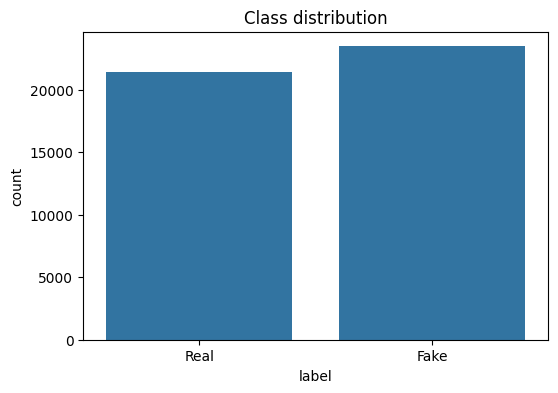

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


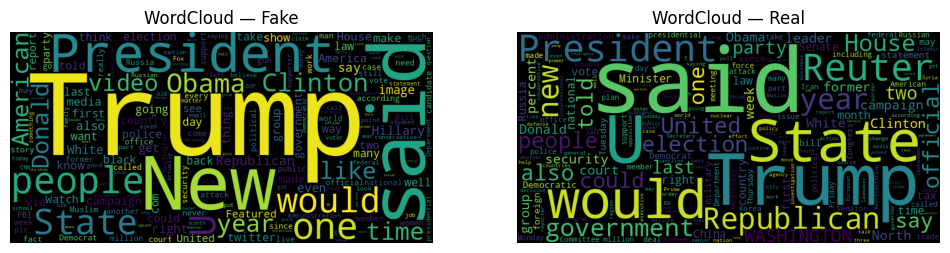

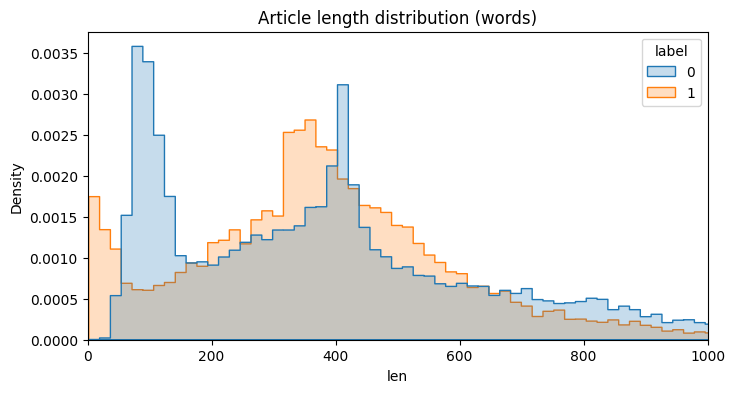

In [ ]:
# -----------------------------------------------------------------------------
# 3. Quick EDA & Visualizations
# -----------------------------------------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.xticks([0,1], ['Real','Fake'])
plt.title('Class distribution')
plt.show()


# Wordclouds for each class (simple)
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))


fake_text = ' '.join(df[df['label']==1]['content'].astype(str).tolist())
real_text = ' '.join(df[df['label']==0]['content'].astype(str).tolist())


wc = WordCloud(width=800, height=400, stopwords=stops, collocations=False)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wc.generate(fake_text))
plt.axis('off')
plt.title('WordCloud — Fake')


plt.subplot(1,2,2)
plt.imshow(wc.generate(real_text))
plt.axis('off')
plt.title('WordCloud — Real')
plt.show()


# Article length distribution
df['len'] = df['content'].str.split().apply(len)
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='len', hue='label', element='step', stat='density', common_norm=False)
plt.xlim(0,1000)
plt.title('Article length distribution (words)')
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# 4. Train/test split (stratified)
# -----------------------------------------------------------------------------
X = df['content'].values
y = df['label'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (38163,) Test: (6735,)


Training TF-IDF + LinearSVC...
TF-IDF + SVM Test Acc: 0.9974758723088345
              precision    recall  f1-score   support

           0     0.9960    0.9988    0.9974      3213
           1     0.9989    0.9963    0.9976      3522

    accuracy                         0.9975      6735
   macro avg     0.9974    0.9975    0.9975      6735
weighted avg     0.9975    0.9975    0.9975      6735



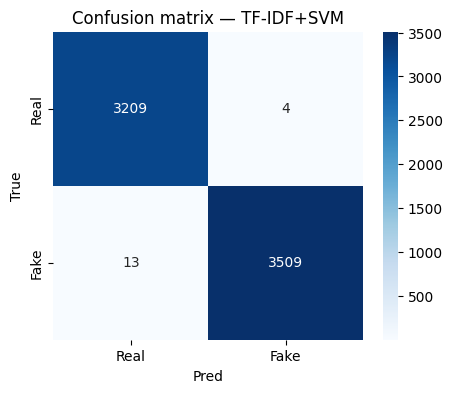

In [ ]:
# -----------------------------------------------------------------------------
# 5. Strong classical baseline: TF-IDF + LinearSVC (with char ngrams option)
# -----------------------------------------------------------------------------
pipe = Pipeline([
('tfidf', TfidfVectorizer(strip_accents='unicode', lowercase=True, max_df=0.95, min_df=3, ngram_range=(1,2))),
('clf', LinearSVC(class_weight='balanced', max_iter=10000))
])


print('Training TF-IDF + LinearSVC...')
pipe.fit(X_train, y_train)


pred = pipe.predict(X_test)
print('TF-IDF + SVM Test Acc:', accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=4))


# Confusion matrix plot
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Pred')
plt.ylabel('True')
plt.title('Confusion matrix — TF-IDF+SVM')
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# 6. Transformer: Fine-tune DistilBERT (best accuracy route)
# -----------------------------------------------------------------------------
# Define the model name
model_name = 'distilbert-base-uncased'

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['content'], truncation=True, padding=True)

# Create Datasets from train/test splits
# Use the original train/test split and create a validation set from the training data
X_train_trf, X_val_trf, y_train_trf, y_val_trf = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=SEED)


train_df = pd.DataFrame({'content': X_train_trf.tolist(), 'label': y_train_trf.tolist()})
val_df = pd.DataFrame({'content': X_val_trf.tolist(), 'label': y_val_trf.tolist()})
# Use the original held-out test set (X_test, y_test) for the final evaluation
test_df = pd.DataFrame({'content': X_test.tolist(), 'label': y_test.tolist()})


train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)


# Set format for PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# Load model
model = DistilBertForSequenceClassification.from_pretrained(model_name , num_labels=2)

# Import and move model to XLA device if using TPU
try:
    import torch_xla.core.xla_model as xm
    # Check if running on XLA device (TPU)
    if 'xla' in str(xm.xla_device()):
        device = xm.xla_device()
        model.to(device)
        print("Using XLA device (TPU)")
    else:
        # Use GPU if available, otherwise CPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        print(f"Using device: {device}")
except ImportError:
    # torch_xla is not installed, use GPU or CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Using device: {device}")


# Training arguments: adjust batch size if you have limited GPU
training_args = TrainingArguments(
    output_dir='./distilbert-fake-news',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=2,
    logging_dir='./logs',
)


# Metric
f1 = evaluate.load('f1')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, preds), 'f1': f1.compute(predictions=preds, references=labels)['f1']}

# Define optimizer with fused=False
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay, fused=False)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None) # Pass the optimizer to the Trainer
)


# Start training (this will require a GPU for reasonable speed)
trainer.train()


# After training, evaluate and show classification report
preds_output = trainer.predict(test_ds) # Use the new test_ds for final evaluation
preds = np.argmax(preds_output.predictions, axis=1)
# Use the original y_test NumPy array for scikit-learn metrics
print('Transformer Test Acc:', accuracy_score(y_test, preds))
print(classification_report(y_test, preds, digits=4))

Map:   0%|          | 0/34346 [00:00<?, ? examples/s]

Map:   0%|          | 0/3817 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


In [ ]:
!pip install -q optimum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 2.2 MB/s eta 0:00:00


KeyboardInterrupt: 

In [ ]:
# -------------------------------------------------------------------------
# 7. Ensemble: simple average of TF-IDF+SVM and Transformer probabilities
# -------------------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler

print("\nPerforming Ensemble (average of SVM + Transformer)...")

# ---- 1️⃣ Get calibrated probabilities for TF-IDF + SVM ----
# LinearSVC doesn’t output probabilities, so we refit a LogisticRegression on the same TF-IDF features.
tfidf_vectorizer = pipe.named_steps['tfidf']
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a Logistic Regression on the TF-IDF features (for probabilistic output)
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced')
log_reg.fit(X_train_tfidf, y_train)

# Get predicted probabilities from TF-IDF model
probs_tfidf = log_reg.predict_proba(X_test_tfidf)

# ---- 2️⃣ Get probabilities from Transformer (DistilBERT) ----
# The trainer already returned logits in preds_output
logits_trf = preds_output.predictions
probs_trf = torch.nn.functional.softmax(torch.tensor(logits_trf), dim=1).numpy()

# ---- 3️⃣ Normalize both probability distributions to same scale ----
scaler = MinMaxScaler()
probs_tfidf_scaled = scaler.fit_transform(probs_tfidf)
probs_trf_scaled = scaler.fit_transform(probs_trf)

# ---- 4️⃣ Average the probabilities (equal weights) ----
probs_ensemble = (probs_tfidf_scaled + probs_trf_scaled) / 2.0
preds_ensemble = np.argmax(probs_ensemble, axis=1)

# ---- 5️⃣ Evaluate the Ensemble ----
acc_ensemble = accuracy_score(y_test, preds_ensemble)
f1_ensemble = f1_score(y_test, preds_ensemble)

print("\n✅ Ensemble Model Results")
print(f"Accuracy : {acc_ensemble*100:.2f}%")
print(f"F1-score : {f1_ensemble:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, preds_ensemble, digits=4))

# ---- 6️⃣ Confusion matrix ----
cm = confusion_matrix(y_test, preds_ensemble)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Ensemble (TF-IDF+Transformer)')
plt.show()

# ---- 7️⃣ Compare all model accuracies ----
models = ['TF-IDF+SVM', 'Transformer', 'Ensemble']
accuracies = [
    accuracy_score(y_test, pred),          # from TF-IDF+SVM
    accuracy_score(y_test, preds),         # from Transformer
    acc_ensemble
]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f"{v*100:.2f}%", ha='center')
plt.show()


In [ ]:
# -----------------------------------------------------------------------------
# 8. Save models and final notes
# -----------------------------------------------------------------------------
# Save classical model
import joblib
joblib.dump(pipe, 'tfidf_svm_pipeline.joblib')


# Save tokenizer and (after training) model
tokenizer.save_pretrained('./distilbert-tokenizer')

# Import torch_xla for TPU saving
import torch_xla.core.xla_model as xm

# Check if running on XLA device (TPU) and save accordingly
if 'xla' in str(xm.xla_device()):
    # Save model on TPU using xm.save
    xm.save(model.state_dict(), './distilbert-fake-news-model/pytorch_model.bin')
    # Optionally save config.json separately if needed
    model.config.to_json_file('./distilbert-fake-news-model/config.json')
else:
    # Save model on other devices using save_pretrained
    model.save_pretrained('./distilbert-fake-news-model')


print('Notebook finished. Review comments above to run trainer.train() if you have GPU.\n')

Notebook finished. Review comments above to run trainer.train() if you have GPU.



/tmp/ipython-input-2553331035.py:16: DeprecationWarning: Use torch_xla.device instead
  if 'xla' in str(xm.xla_device()):
